Investigation of DMA-MR (Direct Methane Aromatization Membrane Reactor) model applied to automatic differentiation
==============================================================================

**Author: Victor Alves**

The DMA-MR model schematic and equations in a glimpse:
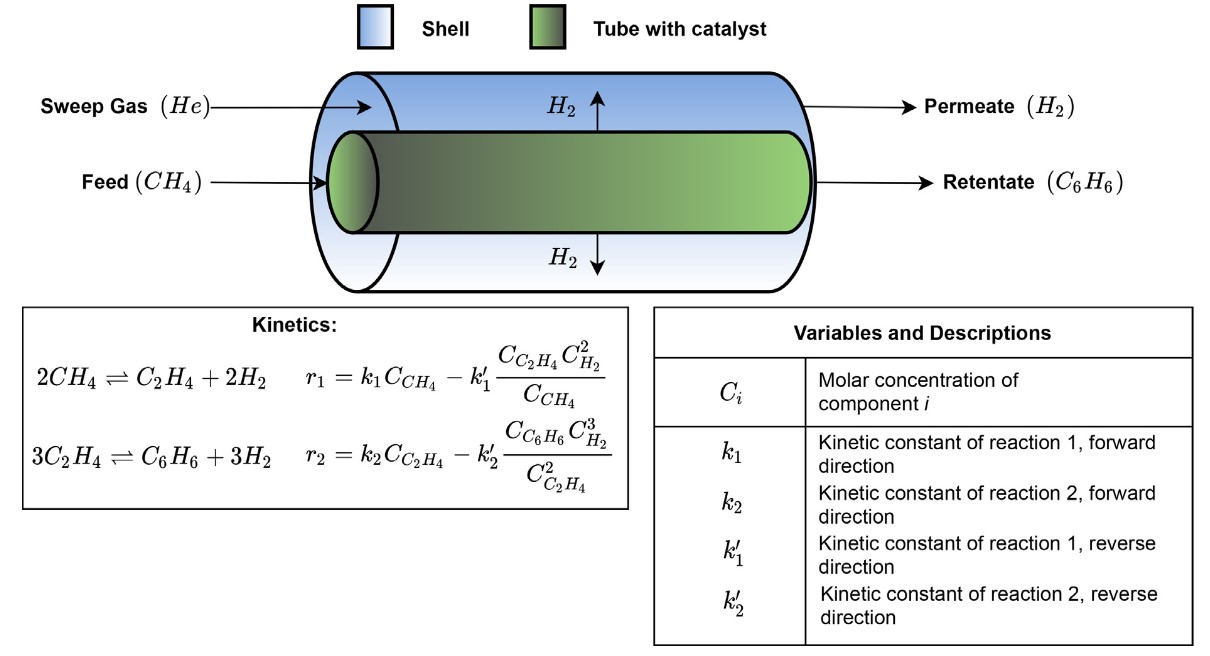

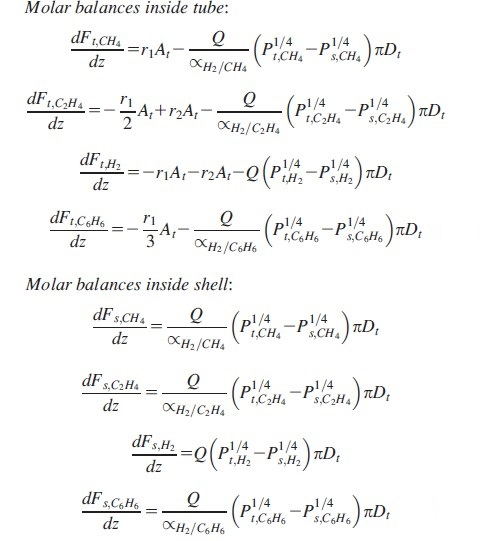

References:
 

1.   A machine learning-based process operability framework using Gaussian processes (https://www.sciencedirect.com/science/article/pii/S0098135422001739) 
2.   Novel Operability-Based Approach for Process Design and
Intensification: Application to a Membrane Reactor for Direct
Methane Aromatization (https://aiche.onlinelibrary.wiley.com/doi/abs/10.1002/aic.15439)




The inputs are the tube length and tube diameter [cm] and as ouputs Benzene production [mg/h] and methane conversion [%], which are calculated using the solution from the ODE system. Therefore, this corresponds to a design problem.

## Obtaining the solution with jax

This allows to have iteractive plots (zoom in/out etc)

In [28]:
from jax.config import config
from jax import lax
config.update("jax_enable_x64", True)

import jax.numpy as np
from jax.experimental.ode import odeint
import matplotlib.pyplot as plt

pi = np.pi

Defining all parameters that are needed to run the model
.

In [29]:
# Kinetic  and general parameters
R = 8.314e6                 # [Pa.cm³/(K.mol.)]
k1 = 0.04                   # [s-¹]
k1_Inv = 6.40e6             # [cm³/s-mol]
k2 = 4.20                   # [s-¹]
k2_Inv = 56.38              # [cm³/s-mol]

# Molecular weights
MM_B = 78.00                # [g/mol] Benzene


# Fixed Reactor Values
T = 1173.15                 # Temperature[K]  =900[°C] (Isothermal)
Q = 3600 * 0.01e-4          # [mol/(h.cm².atm1/4)]
selec = 1500

# Tube side
Pt = 101325.0               # Pressure [Pa](1atm)
v0 = 3600 * (2 / 15)        # Vol. Flowrate [cm³ h-¹]
Ft0 = Pt * v0 / (R * T)     # Initial molar flowrate[mol/h] - Pure CH4

# Shell side
Ps = 101325.0               # Pressure [Pa](1atm)
ds = 3                      # Diameter[cm]
v_He = 3600 * (1 / 6)       # Vol. flowrate[cm³/h]
F_He = Ps * v_He / (R * T)  # Sweep gas molar flowrate [mol/h]



# Initial conditions
y0 = np.hstack((Ft0, np.zeros(7)))


rtol, atol = 1e-10, 1e-10

Defining the DMA-MR model

In [30]:
def dma_mr(z, F, dt):
    
    At = 0.25 * pi * (dt ** 2)  # Cross sectional area[cm³]
    
    # Avoid negative flows that can happen in the first integration steps.
    # Consequently this avoids that any molar balance (^ 1/4 terms) generates
    # complex numbers.
    F = np.where(F <= 1e-9, 1e-9, F)
    

    
    # Evaluate total flowrate in tube & shell.
    Ft = F[0:4].sum()
    Fs = F[4:].sum() + F_He
    v = v0 * (Ft / Ft0)

    # Concentrations from molar flowrates [mol/cm3]
    C = F[:4] / v
    # Partial pressures - Tube & Shell [mol/cm3]

    P0t = (Pt / 101325) * (F[0] / Ft)
    P1t = (Pt / 101325) * (F[1] / Ft)
    P2t = (Pt / 101325) * (F[2] / Ft)
    P3t = (Pt / 101325) * (F[3] / Ft)

    P0s = (Ps / 101325) * (F[4] / Fs)
    P1s = (Ps / 101325) * (F[5] / Fs)
    P2s = (Ps / 101325) * (F[6] / Fs)
    P3s = (Ps / 101325) * (F[7] / Fs)
    
    

    
    r0 = 3600 * k1 * C[0] * (1 - ((k1_Inv * C[1] * C[2] ** 2) / 
                                  (k1 * (C[0])**2 )))
    

    # This replicates an if statement whenever the concentrations are near zero
    C0_aux = C[0]
    r0 = np.where(C0_aux <= 1e-9, 0, r0)
    
    r1 = 3600 * k2 * C[1] * (1 - ((k2_Inv * C[3] * C[2] ** 3) / 
                                  (k2 * (C[1])**3 )))
    

    # Same as before
    C1_aux = C[1]
    r1 = np.where(C1_aux <= 1e-9 , 0, r1)  

    # Molar balances adjustment with experimental data.
    eff = 0.9
    vb = 0.5
    Cat = (1 - vb) * eff

    # Molar balances dFdz - Tube (0 to 3) & Shell (4 to 7)
    dF0 = -Cat * r0 * At - (Q / selec) * ((P0t ** 0.25) - (P0s ** 0.25)) * pi * dt
    dF1 = 1 / 2 * Cat * r0 * At - Cat * r1 * At - (Q / selec) * ((P1t ** 0.25) - (P1s ** 0.25)) * pi * dt
    dF2 = Cat * r0 * At + Cat * r1 * At- (Q) * ((P2t ** 0.25) - (P2s ** 0.25)) * pi * dt
    dF3 = (1 / 3) * Cat * r1 * At - (Q / selec) * ((P3t ** 0.25) - (P3s ** 0.25)) * pi * dt
    dF4 = (Q / selec) * ((P0t ** 0.25) - (P0s ** 0.25)) * pi * dt
    dF5 = (Q / selec) * ((P1t ** 0.25) - (P1s ** 0.25)) * pi * dt
    dF6 = (Q) * ((P2t ** 0.25) - (P2s ** 0.25)) * pi * dt
    dF7 = (Q / selec) * ((P3t ** 0.25) - (P3s ** 0.25)) * pi * dt
    
    dFdz = np.array([ dF0, dF1, dF2, dF3, dF4, dF5, dF6, dF7 ])

    return dFdz

# reverse args for odeint
dma_mr_ad = lambda F, z, dt: dma_mr(z, F, dt)

Defining a meshgrid for length (l) and diameter (d) ranging from [0.5-2] and [10-100] respectively, following the example from the MATLAB App project developed for Process Operability calculations (available at: https://fernandolima.faculty.wvu.edu/files/d/e563f46c-bbd1-4a1f-a7d7-55095ef36dfe/documentation_1-2_05_2021.pdf)

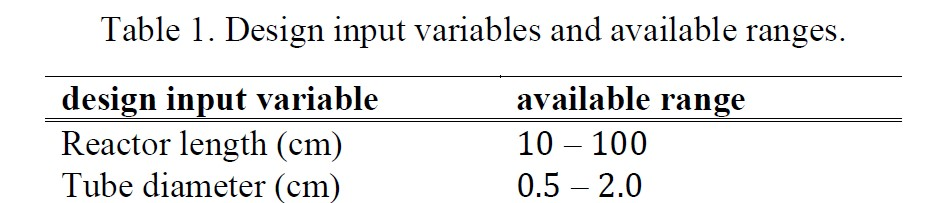

In [31]:
n = 60
dt = np.linspace(0.5, 2, n)        # Tube diameter [cm]
l = np.linspace(10.00, 100.00, n)  # Tube length

dt, l = np.meshgrid(dt, l)         # Mesh

dt = dt.flatten()
l = l.flatten()

design = np.c_[l, dt]              # Design vector

Solving the forward mapping for a 60x60 grid

In [32]:
y = []
for i, (_l, _dt) in enumerate(design):
    
    z = np.linspace(0, _l, 2000)
    F = odeint(dma_mr_ad, y0, z, _dt, rtol=rtol, atol=atol)
    

    thisy = [
        float((F[-1, 3] * 1000) * MM_B),  # F_C6H6
        float(100 * (Ft0 - F[-1, 0] - F[-1, 4]) / Ft0),
    ]  # X_CH4

    y += [thisy]

    print(f'{i}, ({_dt:1.2f}, {_l:1.2f}), {y[i]}')
y = np.array(y)

0, (0.50, 10.00), [13.146160675208733, 22.15292410899064]
1, (0.53, 10.00), [14.190450546442188, 23.855573994675865]
2, (0.55, 10.00), [15.197707780338844, 25.505085182632357]
3, (0.58, 10.00), [16.15648469814297, 27.082425092256816]
4, (0.60, 10.00), [17.056748561787998, 28.570958421835524]
5, (0.63, 10.00), [17.890523833428695, 29.957431567433407]
6, (0.65, 10.00), [18.652287886058197, 31.232625545413377]
7, (0.68, 10.00), [19.339121975476793, 32.39157343032039]
8, (0.70, 10.00), [19.950657180426187, 33.43334551627512]
9, (0.73, 10.00), [20.488692530315284, 34.36052858426484]
10, (0.75, 10.00), [20.956746332869688, 35.17849008826736]
11, (0.78, 10.00), [21.359616297857794, 35.89455805709401]
12, (0.81, 10.00), [21.702839121016865, 36.517282225240635]
13, (0.83, 10.00), [21.99228781840949, 37.05578489180442]
14, (0.86, 10.00), [22.233914010026812, 37.519237043886584]
15, (0.88, 10.00), [22.43343061517426, 37.91652101060195]
16, (0.91, 10.00), [22.59621042252728, 38.25597496800243]
17,

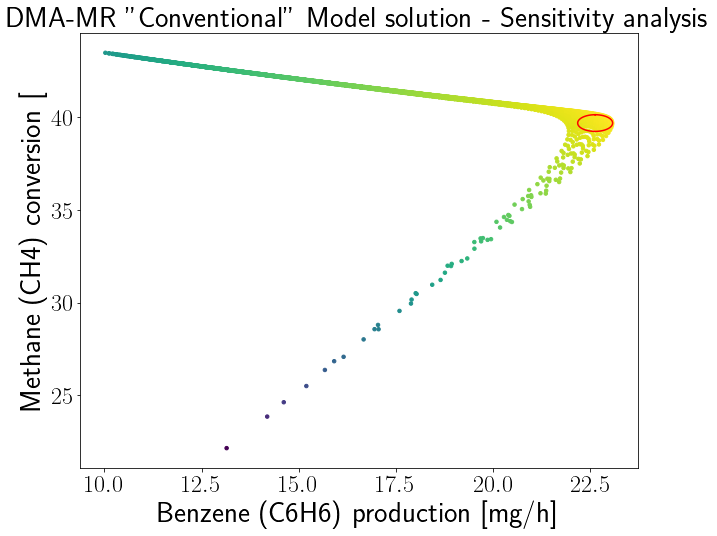

In [33]:
plt.rcParams['figure.figsize'] = [10, 8]
plt.scatter(y[:, 0], y[:, 1], s=12, c=np.sqrt(y[:, 0] ** 0.5 + y[:, 1] ** 0.5))


p = 22.63, 39.7                # Values within the banana-shaped curve
r = 0.45


theta = np.linspace(0, 2 * np.pi)
px = r*np.sin(theta) + p[0]
py = r*np.cos(theta) + p[1]

plt.plot(px, py, "r-")

plt.ylabel("Methane (CH4) conversion [%]")
plt.xlabel("Benzene (C6H6) production [mg/h]")
plt.title('DMA-MR "Conventional" Model solution - Sensitivity analysis');

Good news, this looks qualitatively correct now. Note that since the span of input variables was reduced, the banana-shape region/size was also reduced as well.

## Continuing with the proposed approach by Dr. Kitchin

Now that we have figured out and fixed the model to have the correct behavior (Thanks Dr. Kitchin :) ), Let's follow the proposed approach. Defining an auxiliary function in which the derivatives will be taken based on it.

small function that calculates the outputs (Benzene production and methane conversion) based on the ODE system states

In [34]:
def F(l, dt, benz, conv):
    
    z = np.linspace(0, l, 2000)
    F = odeint(dma_mr_ad, y0, z, dt, rtol=rtol, atol=atol)
    

    
    F_C6H6 = ((F[-1, 3] * 1000) * MM_B)
    X_CH4  = (100 * (Ft0 - F[-1, 0] - F[-1, 4]) / Ft0)

    

    z1 = benz - F_C6H6
    z2 = conv - X_CH4
    return np.array([z1, z2])

Now, take the derivatives

In [35]:
from jax import jacfwd,jacrev


dFdL  = jacrev(F, 0)
dFdz  = jacrev(F, 1)
dFdB  = jacrev(F, 2)
dFdX  = jacrev(F, 3)

In [36]:
def fprime(i1, i2, o1, o2):
    """returns
    di1/do1  di2/do1
    di1/do2  di2/do2

    From:
    0 = dF/di di/do + dF/do

    di/do = -dF/do / dF/di
    or
    di/do = -(dF/di)^-1 @ dF/do

    """
    dFdo = np.array([dFdB(i1, i2, o1, o2), dFdX(i1, i2, o1, o2)]).squeeze()
    dFdi = np.array([dFdL(i1, i2, o1, o2),  dFdz(i1, i2, o1, o2)]).squeeze()

    di_do = -dFdo @ np.linalg.pinv(dFdi)
    
    return di_do

In [37]:
from scipy.optimize import root

p = 22.63, 39.7                # Values within the banana-shaped curve
r = 0.45

theta = np.linspace(0, 2 * np.pi, 100)
pX = r*np.sin(theta) + p[0]
pY = r*np.cos(theta) + p[1]

path = np.array([pX, pY]).T
dpath = path[1:] - path[:-1]
sol = root(lambda X, benz, conv: F(X[0], X[1], benz, conv), [8, 0.5],
           args=(path[0][0], path[0][1]))


print(sol)

    fjac: array([[ 0.83387425, -0.55195447],
       [ 0.55195447,  0.83387425]])
     fun: array([1.96109795e-12, 1.11555210e-12])
 message: 'The solution converged.'
    nfev: 43
     qtf: array([-5.44068767e-10, -1.06039900e-09])
       r: array([ 0.1484285 ,  1.74700718, -0.25639511])
  status: 1
 success: True
       x: array([12.95735266,  1.18764575])


In [38]:
fprime(*sol.x, *path[0])

DeviceArray([[-24.88675271,   1.66941692],
             [-45.5697324 ,   4.11181406]], dtype=float64)

Finally! The good news is that now I have observed that the values of the derivatives do not go to zero/NaN. Before doing the changes in the model, they would be zero/NaN quite often.

In [39]:
# starting point
i1, i2, o1, o2 = *sol.x, *path[0]
inp = [[i1, i2]]
out = [[o1, o2]]

# Now iterate on each point and update the variables.
for i, h in enumerate(dpath):

    # h is the step, do1, do2
    #
    # fp is di1/do1, di1/do2
    #       di2/do1, di2/do2
    #
    # in this form, it is y' = f(y, t)
    # where (i1, i2) are the dependent y terms),
    # and (o1, o2) are the independent t vars
    
    do1, do2 = h
    
    # k1 = f'(y, t)
    k1 = fprime(i1, i2, o1, o2)
    hk11, hk12 = np.sum(k1 * h[:, None], axis=0)

    # k2 = f'(y + h * k1 / 2, t + h/2)
    k2 = fprime(i1 + hk11 / 2, i2 + hk12 / 2, o1 + do1 / 2, o2 + do2 / 2)
    hk21, hk22 = np.sum(k2 * h[:, None], axis=0)

    # k3 = f'(y + h k2 / 2, t + h / 2)
    k3 = fprime(i1 + hk21 / 2, i2 + hk22 / 2, o1 + do1 / 2, o2 + do2 / 2)
    hk31, hk32 = np.sum(k3 * h[:, None], axis=0)

    # k4 = f'(y + h * k3, t + h)
    k4 = fprime(i1 + hk31, i2 + hk32, o1 + do1, o2 + do2)

    # dy = h / 6 * (k1 + 2 k2 + 2 k3 + k4) 
    dy = h[:, None] / 6 * (k1 + 2 * k2 + 2 * k3 + k4)

    di1, di2 = np.sum(dy, axis=0)
    
    o1 = o1 + h[0]
    o2 = o2 + h[1]
            
    i1 = i1 + di1
    i2 = i2 + di2

    # Raise Exception: If the solution is not essentially zero, tune it
    if not (np.all(np.abs(F(i1, i2, o1, o2)) < 1e-2)):
        print(i1, i2, o1, o2, F(i1, i2, o1, o2))
        ## Added fine tuning for solution. Tested and working
        sol = root(lambda X, benz, conv: F(X[0], X[1], benz, conv), [i1,  i2],
           args=(o1, o2))
        i1, i2  = sol.x[0], sol.x[1]
        # Just printing to check if it actually found the zero.
        print(i, sol.success, sol.fun, i1,i2)
        
    
    inp += [[i1, i2]]
    out += [[o1, o2]]

inp = np.array(inp)
out = np.array(out)

The predictor - corrector is implemented and working, but it was not invoked here in this specific case.



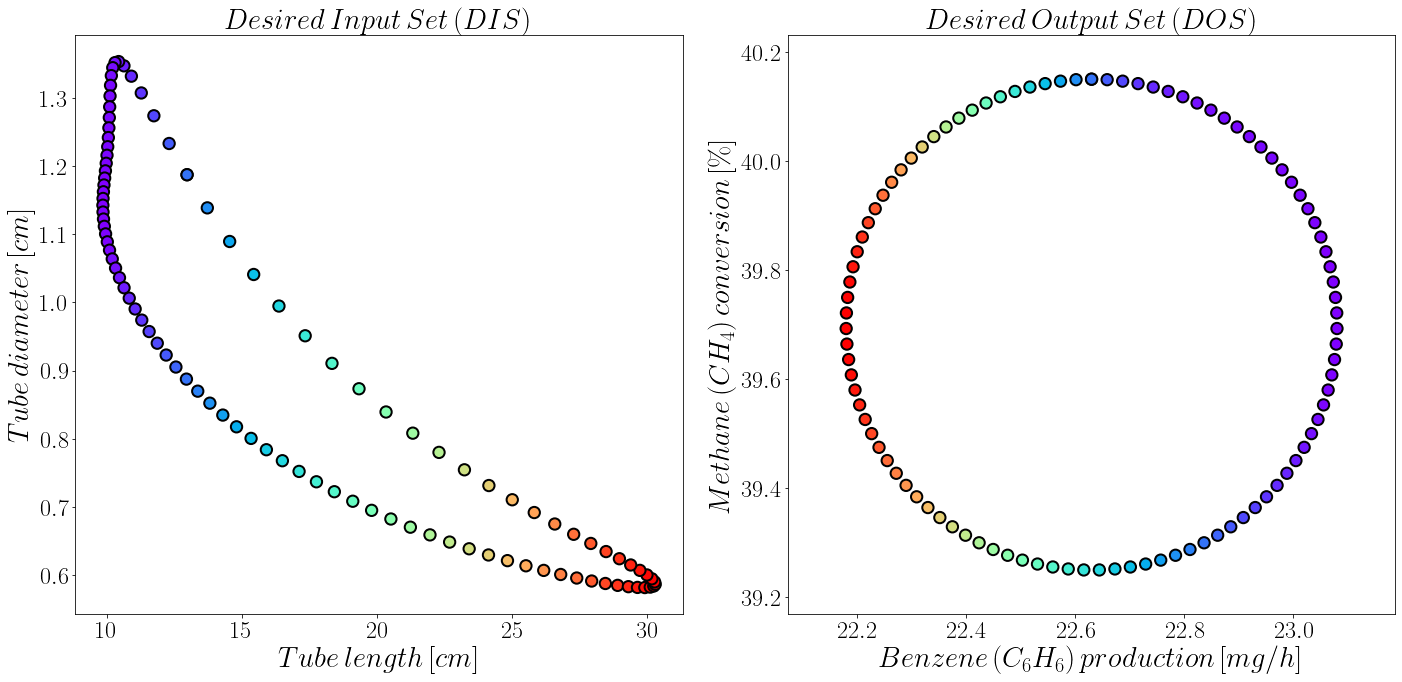

In [40]:
plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams['font.size'] = 24
plt.rcParams['text.usetex'] = True


cmap =  'rainbow'
lineweight = 2
edgecolors = 'k'
markersize =  128

# Corresponding path in input space
plt.subplot(121)

plt.title('$Desired \, Input \, Set \, (DIS)$')
plt.scatter(inp[:, 0], inp[:, 1], c=np.sqrt(inp[:,0]**2 + inp[:,1]**2), 
cmap=cmap, marker= 'o', antialiased=True,  lw=lineweight, edgecolors =edgecolors, s = markersize)
plt.xlabel('$Tube  \, length \, [cm]$')
plt.ylabel('$Tube \, diameter \, [cm]$')


# Plot output space path
plt.subplot(122)
plt.scatter(out[:,0], out[:, 1], c=np.sqrt(inp[:,0]**2 + inp[:,1]**2), 
cmap=cmap, marker= 'o', antialiased=True,  lw=lineweight, edgecolors =edgecolors, s = markersize)

plt.xlabel('$ Benzene \, (C_{6}H_{6}) \, production \,[mg/h]$')
plt.ylabel('$Methane\, (CH_{4})  \, conversion \,[\%]$')
plt.axis('equal')
plt.title('$Desired \, Output \, Set \, (DOS)$')
plt.tight_layout()

#mpl.rcParams['lines.linestyle'] = '--'
plt.savefig("./article inverse mapping/fig1_dma_mr.pdf", format="pdf", bbox_inches="tight")

Since I reduced the span of the input variables, their inverse mapping looks "less stiff" (shape-wise)


Now, let's test the foward mapping to double check if this was correct.

In [41]:
l2, dt2 = inp[:,0], inp[:,1]
y_check = []
for i, (_l2, _dt2) in enumerate(inp):
    
    z = np.linspace(0, _l2)
    sol = odeint(dma_mr_ad, y0, z, _dt2, rtol=rtol, atol=atol)
    
    
    F = sol

    thisy = [
        float((F[-1, 3] * 1000) * MM_B),  # F_C6H6
        float(100 * (Ft0 - F[-1, 0] - F[-1, 4]) / Ft0),
    ]  # X_CH4

    y_check += [thisy]

    print(f'{i}, ({_dt2:1.2f}, {_l2:1.2f}), {y_check[i]}')
y_check = np.array(y_check)

0, (1.19, 12.96), [22.629999999998038, 40.14999999999889]
1, (1.23, 12.29), [22.65858634243286, 40.14907928684387]
2, (1.27, 11.73), [22.68694164286545, 40.14638767626687]
3, (1.31, 11.26), [22.715183535476474, 40.14186128188045]
4, (1.33, 10.89), [22.742993052444085, 40.13558437920948]
5, (1.35, 10.62), [22.77038813853801, 40.12754054890558]
6, (1.35, 10.42), [22.797239073904258, 40.11776835470343]
7, (1.35, 10.29), [22.823383776145715, 40.106324520401515]
8, (1.34, 10.20), [22.84876386171652, 40.09324002977564]
9, (1.33, 10.15), [22.87328439079229, 40.0785652309363]
10, (1.32, 10.12), [22.89681115022399, 40.062370721199684]
11, (1.30, 10.10), [22.919256126945484, 40.04471936242831]
12, (1.29, 10.09), [22.940536924412864, 40.02567975401223]
13, (1.27, 10.08), [22.960566940546084, 40.00532885703403]
14, (1.26, 10.06), [22.97926067853281, 39.98375017793358]
15, (1.24, 10.04), [22.996564859816704, 39.961023540145746]
16, (1.23, 10.02), [23.012380004628554, 39.937250032847494]
17, (1.22, 

In [42]:
print(l2.flatten().size)

100


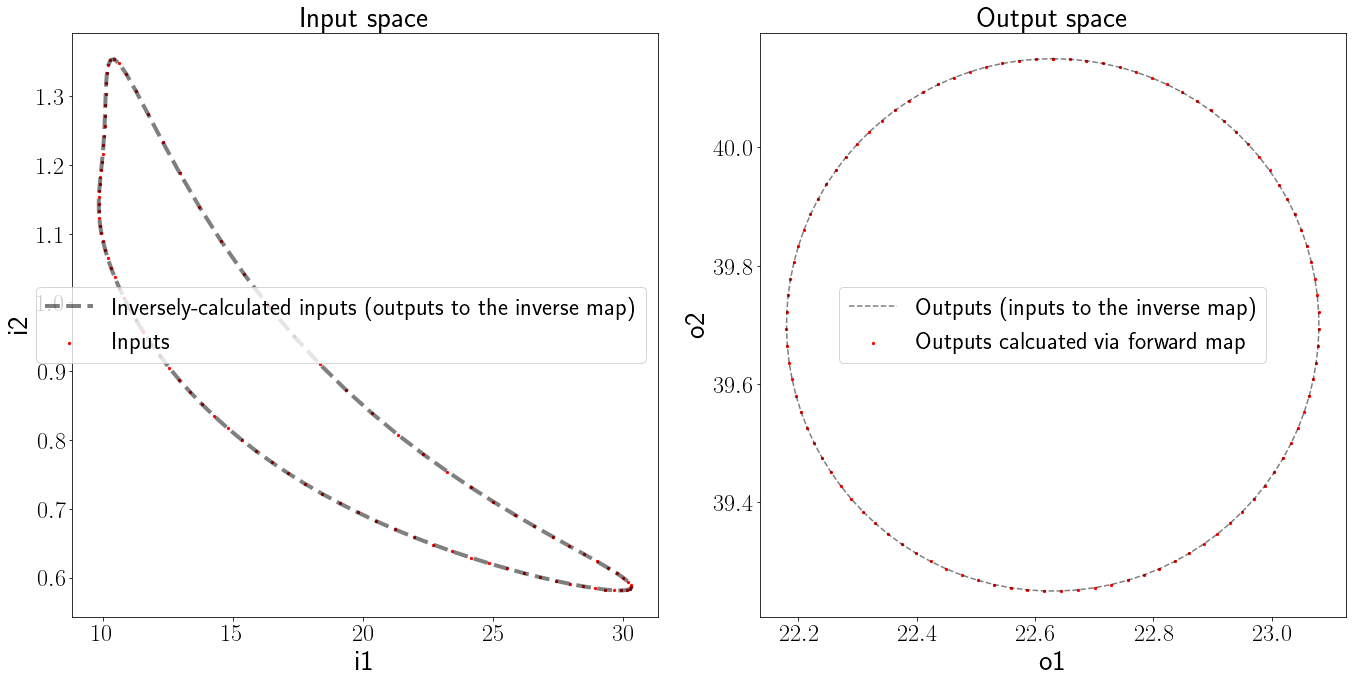

In [43]:
plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams['font.size'] = 24
# Corresponding path in input space
plt.subplot(121)

plt.title('input space')
plt.plot(inp[:, 0], inp[:, 1], lw=4, alpha=0.5, c="k",label='Inversely-calculated inputs (outputs to the inverse map)',ls='--')
plt.scatter(l2.flatten(), dt2.flatten(),c="r",label='Inputs', s=5)
plt.legend()
plt.xlabel('i1')
plt.ylabel('i2')
plt.title('Input space')

# Plot output space path
plt.subplot(122)
plt.plot(out[:,0], out[:, 1],alpha=0.5, c="k",label='Outputs (inputs to the inverse map)',ls='--')
plt.scatter(y_check[:,0], y_check[:,1],c="r",label='Outputs calcuated via forward map', s=5)
plt.xlabel('o1')
plt.ylabel('o2')
plt.axis('equal')
plt.legend()
plt.title('Output space')
plt.tight_layout()

The inverse and foward map yielded the same results!

In [44]:
from jax import vmap

fp = vmap(fprime)(*inp.T, *out.T)
fp.shape

(100, 2, 2)

In [45]:
print(fp)

[[[-2.48867527e+01  1.66941692e+00]
  [-4.55697324e+01  4.11181406e+00]]

 [[-2.45906510e+01  1.82608308e+00]
  [-4.67755666e+01  4.61635489e+00]]

 [[-2.41899237e+01  1.96187676e+00]
  [-4.70680865e+01  5.03404624e+00]]

 [[-2.38624639e+01  2.07017879e+00]
  [-4.67064290e+01  5.32196346e+00]]

 [[-2.33378441e+01  2.13032581e+00]
  [-4.51729990e+01  5.42155417e+00]]

 [[-2.25987882e+01  2.13667683e+00]
  [-4.25112883e+01  5.31846990e+00]]

 [[-2.18156720e+01  2.09960103e+00]
  [-3.92072313e+01  5.04785161e+00]]

 [[-2.11181773e+01  2.03475804e+00]
  [-3.56742953e+01  4.66543259e+00]]

 [[-2.04093429e+01  1.94810697e+00]
  [-3.19157364e+01  4.21236608e+00]]

 [[-1.96886891e+01  1.84918112e+00]
  [-2.81068884e+01  3.73358947e+00]]

 [[-1.90510267e+01  1.75116851e+00]
  [-2.45185443e+01  3.27071231e+00]]

 [[-1.84198131e+01  1.65444335e+00]
  [-2.11324804e+01  2.83789941e+00]]

 [[-1.78989752e+01  1.56857179e+00]
  [-1.81188993e+01  2.45309710e+00]]

 [[-1.74337831e+01  1.49149721e+00]
  

## Plotting derivatives to check smoothness

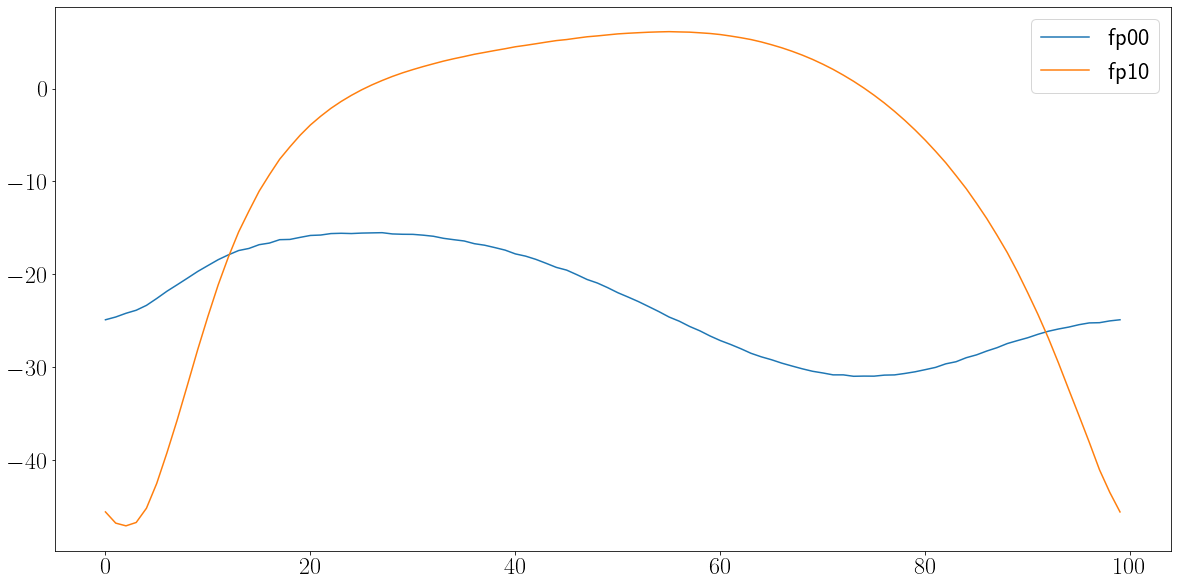

In [46]:
plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams['font.size'] = 24

plt.plot(fp[:, 0, 0], label='fp00')
plt.plot(fp[:, 1, 0], label='fp10')
plt.legend()

Way better now.

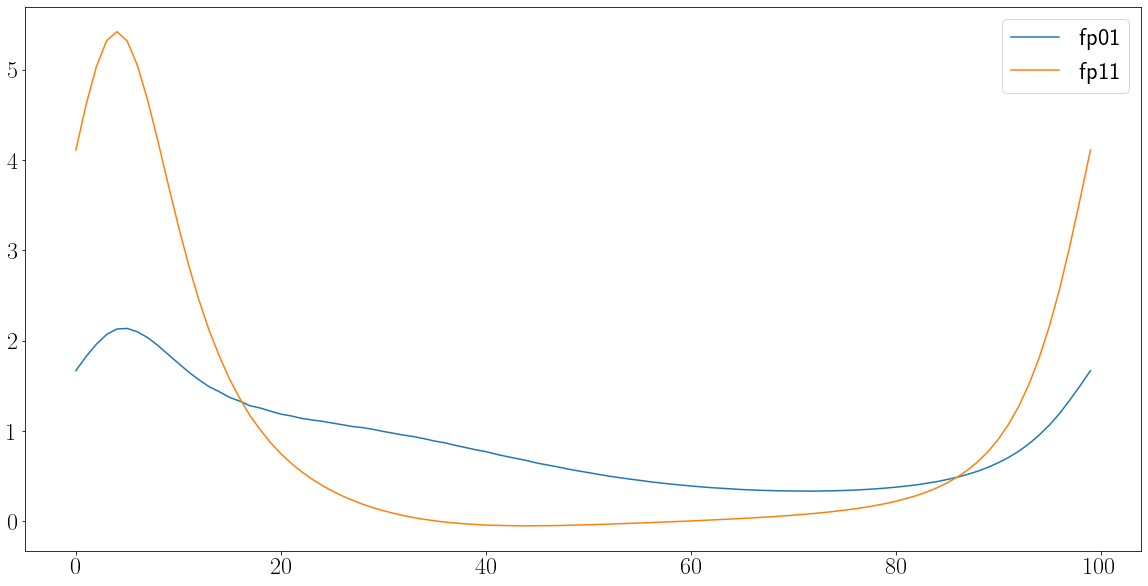

In [47]:
plt.plot(fp[:, 0, 1], label='fp01')
plt.plot(fp[:, 1, 1], label='fp11')
plt.legend()

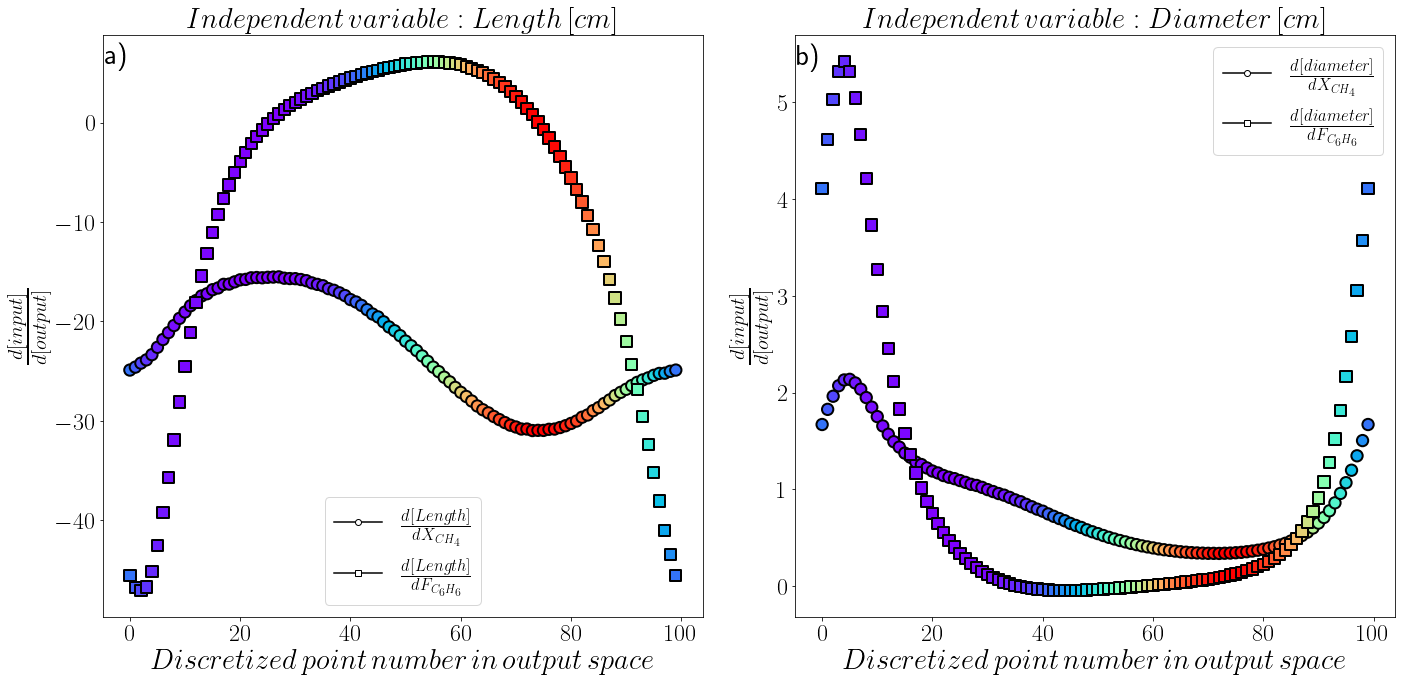

In [48]:
plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams['font.size'] = 24
plt.rcParams['text.usetex'] = True
plt.rcParams['axes.labelsize'] = 'large'
from matplotlib.patches import Rectangle, Circle
from matplotlib.lines import Line2D

# c=np.sqrt(inp[:,0]**2 + inp[:,1]**2), 
# cmap=cmap, marker= 'o', antialiased=True,  lw=lineweight)

# range(fp[:, 2].shape[0])

cmap =  'rainbow'
lineweight = 2
edgecolors = 'k'
markersize =  128

plt.subplot(121)
plt.title('$Independent \, variable: Length \, [cm]$')
plt.scatter(range(fp[:, 0, 0].shape[0]), fp[:, 0, 0],
c=np.sqrt(inp[:,0]**2 + inp[:,1]**2), cmap=cmap, marker= 'o', 
antialiased=True,  lw=lineweight, edgecolors =edgecolors, s = markersize)
plt.text(-4.5, 6.0, 'a)', fontsize='large')


plt.scatter(range(fp[:, 1, 0].shape[0]), fp[:, 1, 0], 
c=np.sqrt(inp[:,0]**2 + inp[:,1]**2), cmap=cmap, marker= 's', 
antialiased=True,  lw=lineweight, edgecolors =edgecolors, s = markersize)
# plt.legend()
# plt.legend()
plt.xlabel('$ Discretized \, point  \, number  \, in \, output \, space $')
plt.ylabel(r'$\frac{d[input]}{d[output]}$')
legend_elements =  [Line2D([0], [0], markerfacecolor='w', color = 'k', 
label= r'$\frac{d[Length]}{dX_{CH_{4}}}$', marker='o'),
Line2D([0], [0], markerfacecolor='w', color = 'k', 
label= r'$\frac{d[Length]}{dF_{C_{6}H_{6}}}$', marker='s')]
ax =  plt.gca()
ax.legend(handles=legend_elements)



plt.subplot(122)
plt.scatter(range(fp[:, 0, 1].shape[0]), fp[:, 0, 1], 
c=np.sqrt(inp[:,0]**2 + inp[:,1]**2), cmap=cmap, marker= 'o',
antialiased=True,  lw=lineweight, edgecolors =edgecolors, s = markersize)


plt.scatter(range(fp[:, 1, 1].shape[0]), fp[:, 1, 1], 
c=np.sqrt(inp[:,0]**2 + inp[:,1]**2), cmap=cmap, marker= 's', 
antialiased=True,  lw=lineweight, edgecolors =edgecolors, s = markersize)


legend_elements2 =  [Line2D([0], [0], markerfacecolor='w', color = 'k', 
label= r'$\frac{d[diameter]}{dX_{CH_{4}}}$', marker='o'),
Line2D([0], [0], markerfacecolor='w', color = 'k', 
label= r'$\frac{d[diameter]}{dF_{C_{6}H_{6}}}$', marker='s')]

ax2 =  plt.gca()
ax2.legend(handles=legend_elements2)



plt.xlabel('$Discretized \, point \, number \, in \, output \, space$')
plt.ylabel(r'$\frac{d[input]}{d[output]}$')
#plt.axis('equal')
plt.title('$Independent \, variable: Diameter \, [cm]$')
plt.text(-4.5, 5.4, 'b)', fontsize='large')
plt.tight_layout()

# plt.savefig("fig3_dma_mr.pdf", format="pdf", bbox_inches="tight")
plt.savefig("./article inverse mapping/fig3_dma_mr.pdf", format="pdf", bbox_inches="tight")

Finally. :)

In [51]:
def F(l, dt, benz, conv):
    
    z = np.linspace(0, l, 2000)
    F = odeint(dma_mr_ad, y0, z, dt, rtol=rtol, atol=atol)
    

    
    F_C6H6 = ((F[-1, 3] * 1000) * MM_B)
    X_CH4  = (100 * (Ft0 - F[-1, 0] - F[-1, 4]) / Ft0)

    

    z1 = benz - F_C6H6
    z2 = conv - X_CH4
    return np.array([z1, z2])

In [52]:


dFdi1  = jacrev(F, 0) # 2d array, (2, 1)
dFdi2 = jacrev(F, 1)
dFdo1 = jacrev(F, 2)
dFdo2 = jacrev(F, 3)

def fprime2(i1, i2, o1, o2):
    """returns
    di1/do1  di2/do1
    di1/do2  di2/do2

    From:
    0 = dF/di di/do + dF/do

    di/do = -dF/do / dF/di
    or
    di/do = -(dF/di)^-1 @ dF/do

    """
    dFdo = np.array([dFdo1(i1, i2, o1, o2), dFdo2(i1, i2, o1, o2)]).squeeze()
    dFdi = np.array([dFdi1(i1, i2, o1, o2),  dFdi2(i1, i2, o1, o2)]).squeeze()

    di_do = -dFdo @ np.linalg.inv(dFdi)
    
    return di_do

In [57]:
from matplotlib.pyplot import quiver



print(inp.shape)
print(out.shape)

# inp = inp.T
# out = out.T
inp, out = inp.T, out.T


# inp = np.array([bR, bRT])
# out = np.array([bCa, bCb])

def fprime_trans(y1, y2, y_new1, y_new2, inp1, inp2):

    inp = np.array([inp1, inp2])
    y   = np.array([y1, y2])
    y_new = np.array([y_new1, y_new2])
    #print(y)
    #print(y_new)
    Jac =  fprime2(*inp, *y).T
    #print(Jacobian)
    return (Jac @ (y - y_new))

#print(R_.T.shape[1])


#teste = np.array((R_).T)
#print(teste)
#print(*R_[:,0])
#print(inp.shape)
#print(out.shape)
dx_est_list = []
dx_est_conc = np.zeros((2,out.shape[1]))
for k in range(out.shape[1]):
#    if k < out.shape[1]:
        dx_est =  - fprime_trans(*out[:,k], *out[:, k+1], *inp[:,k])
        dx_est_list.append(dx_est)
        dx_est_conc = dx_est_conc.at[0:, k].set(dx_est)

(100, 2)
(100, 2)


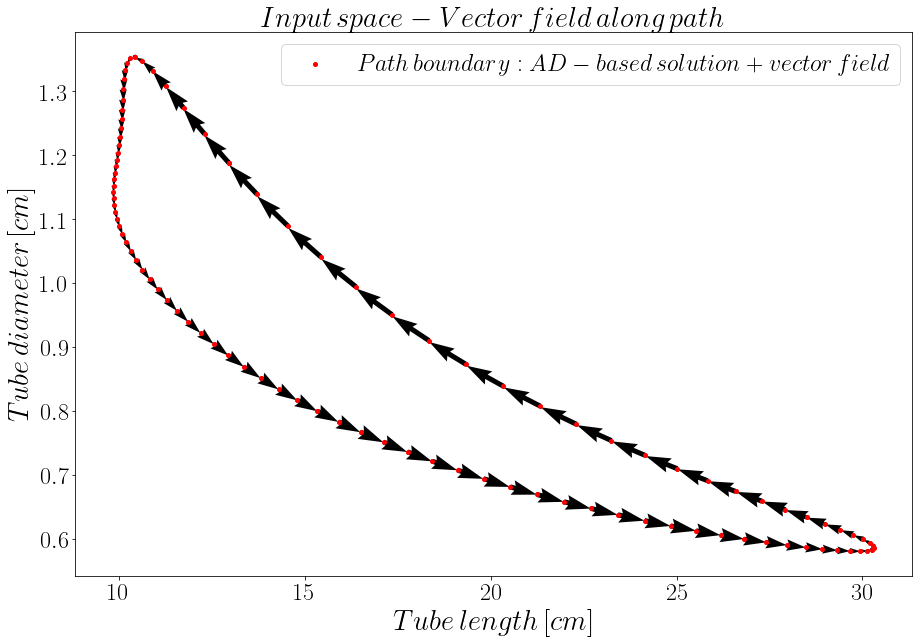

In [58]:
#print(out.shape[1])
#print(inp.shape)
#print(dx_est.shape)

#N = np.sqrt(dx_est_conc[:,0]**2 + dx_est_conc[:,1]**2)
#print(N)
#dx_est_conc = dx_est_conc.at[:,0].set(dx_est_conc[:,0]/N)
#dx_est_conc = dx_est_conc.at[:,1].set(dx_est_conc[:,1]/N)

#quiver(*inp,*dx_est_conc, angles='xy', scale_units = 'xy', scale=1)


plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['font.size'] = 24
plt.rcParams['text.usetex'] = True


# Colored arrows: quiver(*inp,*dx_est_conc, np.arctan2(*dx_est_conc), angles='xy', label='Vector Field', scale_units = 'xy')
#fig1, ax1 = plt.subplots()
quiver(*inp,*dx_est_conc, angles='xy', scale_units = 'xy', scale=1)

plt.scatter(inp.T[:, 0], inp.T[:, 1], c='r',
label = '$Path \, boundary: AD-based \, solution + vector \, field$', lw=1, s=64, marker='.')
#plt.scatter(bR[dos], bRT[dos], s=64, alpha = 0.85,
#label = 'Input discretized solution - Brute-force method', c=np.sqrt(bR[dos]**2 + bRT[dos]**2))
plt.xlabel('$Tube \, length \, [cm]$')
plt.ylabel('$Tube \, diameter \, [cm]$')
plt.title('$Input \, space - Vector \, field \, along \, path$')
# ax1 = plt.gca()
# qkey = ax1.quiverkey(Q, 0.65, 0.75, 2, r'$\frac{\mathrm{d[Tube \, length]} }{\mathrm{d[Tube \, diameter]} }$', labelpos='E',
#                    coordinates='figure')
plt.legend()

plt.savefig("./article inverse mapping/fig4_dma_mr.pdf", format="pdf", bbox_inches="tight")